# Missing value imputation: RandomSampleImputer


The RandomSampleImputer extracts a random sample of observations where data is available, and uses it to replace the NA. It is suitable for numerical and categorical variables.

To control the random sample extraction, there are various ways to set a seed and ensure or maximize reproducibility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.imputation import RandomSampleImputer

# Download the data from Kaggle and store it
# in the same folder as this notebook.

data = pd.read_csv(r'C:\Users\devanshu.tayal\Downloads\houseprices.csv')

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [2]:
# Separate the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((2043, 79), (876, 79))

## Imputation in batch

We can set the imputer to impute several observations in batch with a unique seed. This is the equivalent of setting the `random_state` to an integer in `pandas.sample()`.

In [3]:
# Start the imputer

imputer = RandomSampleImputer(

    # the variables to impute
    variables=['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea'],

    # the random state for reproducibility
    random_state=10,

    # equialent to setting random_state in
    # pandas.sample()
    seed='general',
)

# Stores a copy of the train set variables

imputer.fit(X_train)

RandomSampleImputer(random_state=10,
                    variables=['Alley', 'MasVnrType', 'LotFrontage',
                               'MasVnrArea'])

In [4]:
# the imputer saves a copy of the variables 
# from the training set to impute new data.

imputer.X_.head()

,Alley,MasVnrType,LotFrontage,MasVnrArea
1448,NaN,NaN,70.0,0.0
1397,NaN,NaN,51.0,0.0
1,NaN,NaN,80.0,0.0
384,NaN,NaN,NaN,0.0
530,NaN,BrkFace,85.0,219.0


In [5]:
# Check missing data in train set

X_train[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.934900
MasVnrType     0.603035
LotFrontage    0.162996
MasVnrArea     0.006853
dtype: float64

In [6]:
# impute data

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

# Check missing data after the transformation

train_t[['Alley', 'MasVnrType', 'LotFrontage', 'MasVnrArea']].isnull().mean()

Alley          0.0
MasVnrType     0.0
LotFrontage    0.0
MasVnrArea     0.0
dtype: float64

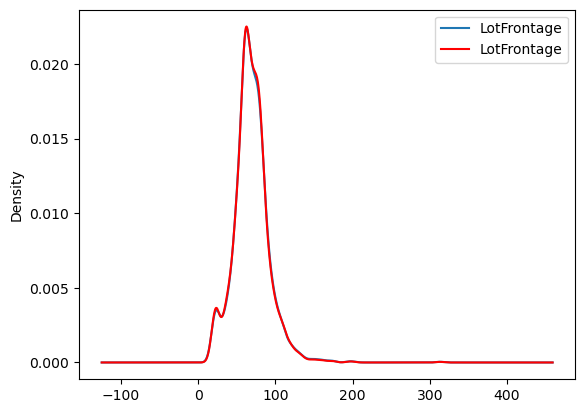

In [7]:
# when using the random sample imputer, 
# the distribution of the variable does not change.

# This imputation method is useful for models that 
# are sensitive to changes in the variable distributions.

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Specific seeds for each observation

Sometimes, we want to guarantee that the same observation is imputed with the same value, run after run. 

To achieve this, we need to always use the same seed for every particular observation. 

To do this, we can use the values in neighboring variables as seed.

In this case, the seed will be calculated observation per observation, either by adding or multiplying the seeding variable values, and passed to the random_state of pandas.sample(), which is used under the hood by the imputer.
Then, a value will be extracted from the train set using that seed and  used to replace the NAN in particular observation.

In [8]:
imputer = RandomSampleImputer(

    # the values of these variables will be used as seed
    random_state=['MSSubClass', 'YrSold'],

    # 1 seed per observation
    seed='observation',

    # how to combine the values of the seeding variables
    seeding_method='add',
    
    # impute all variables, numerical and categorical
    variables=None,
)

# Stores a copy of the train set.

imputer.fit(X_train)

RandomSampleImputer(random_state=['MSSubClass', 'YrSold'], seed='observation')

In [9]:
# takes a copy of the entire train set

imputer.X_

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1448,50,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,5,2007,WD,Normal
1397,70,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
384,60,RL,NaN,53107,Pave,NaN,IR2,Low,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
530,80,RL,85.0,10200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2008,WD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,60,RL,82.0,9430,Pave,NaN,Reg,Lvl,AllPub,Inside,...,180,0,NaN,NaN,NaN,0,7,2009,WD,Normal
835,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
1653,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
2607,20,RL,61.0,33983,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,NaN,0,5,2007,WD,Normal


In [10]:
# imputes all variables.

# this procedure takes a while because it is 
# done observation per observation.

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

# No missing data in any variable
# after the imputation.

test_t.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

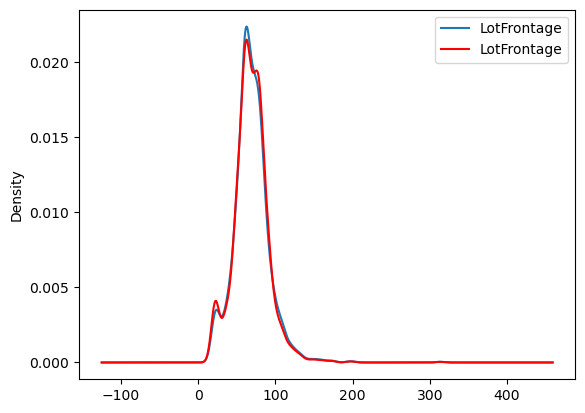

In [11]:
# when using the random sample imputer, 
# the distribution of the variable does not change

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')